In [1]:
from pathlib import Path
import sys
pwd = str(Path("..").absolute())
sys.path.insert(0, pwd)

from Pyrser import pyrser, add_calls
from Node import Node, FileNode, FncNode
from Utils.PyrserHelpers import xfs, dfs_generator
import graphviz; from graphviz import Digraph

In [5]:
file = ".."
output = pyrser(file)

In [8]:
# delete crap from output we don't want in graph
output.children.keys()

dict_keys(['.git', '.ipynb_checkpoints', '.pytest_cache', '.vscode', 'ImportParser.py', 'Node.py', 'Pyrser.py', 'Utils', 'images', 'test_files', 'tests', 'viz'])

In [9]:
del output.children['.git']
del output.children['.ipynb_checkpoints']
del output.children['.pytest_cache']
del output.children['.vscode']
del output.children['tests']
del output.children['test_files']

In [10]:
output

DirNode(name='..', location='..')
 |-- FileNode(name='ImportParser.py', scope=[1, 37], location=../ImportParser.py)
 |    |-- FncNode(name='get_fnc_calls', scope=[16, 30], calls=[])
 |    |-- FncNode(name='get_import_stmt', scope=[31, 37], calls=[])
 |-- FileNode(name='Node.py', scope=[1, 117], location=../Node.py)
 |    |-- ClsNode(name='Node', scope=[4, 52])
 |    |    |-- FncNode(name='add_child', scope=[14, 52], calls=[])
 |    |-- ClsNode(name='DirNode', scope=[55, 58])
 |    |-- ClsNode(name='FileNode', scope=[61, 79])
 |    |-- ClsNode(name='ClsNode', scope=[82, 92])
 |    |-- ClsNode(name='FncNode', scope=[95, 117])
 |    |    |-- FncNode(name='add_call', scope=[101, 117], calls=[])
 |-- FileNode(name='Pyrser.py', scope=[1, 133], location=../Pyrser.py)
 |    |-- FncNode(name='pyrser', scope=[10, 27], calls=[])
 |    |-- FncNode(name='dir_parser', scope=[30, 50], calls=[])
 |    |-- FncNode(name='file_parser', scope=[53, 105], calls=[])
 |    |-- FncNode(name='add_calls', scope=

In [11]:
add_calls(output)

fnc_call: ('dir_parser',), line: output_with_calls = dir_parser(path)
fnc_node: FncNode(name='dir_parser', scope=[30, 50], calls=[])
call_owner: pyrser
caller_node: FncNode(name='pyrser', scope=[10, 27], calls=['is_dir'])
fnc_call: ('dir_parser',), line: child_dir = dir_parser(f)
fnc_node: FncNode(name='dir_parser', scope=[30, 50], calls=['get_file_name_from_path', 'DirNode', 'list_dir', 'nonempty_pyfile', 'get_file_name_from_path', 'reader', 'file_parser', 'add_calls', 'add_child', 'is_dir'])
call_owner: dir_parser
caller_node: FncNode(name='dir_parser', scope=[30, 50], calls=['get_file_name_from_path', 'DirNode', 'list_dir', 'nonempty_pyfile', 'get_file_name_from_path', 'reader', 'file_parser', 'add_calls', 'add_child', 'is_dir'])


In [12]:
output

DirNode(name='..', location='..')
 |-- FileNode(name='ImportParser.py', scope=[1, 37], location=../ImportParser.py)
 |    |-- FncNode(name='get_fnc_calls', scope=[16, 30], calls=[])
 |    |-- FncNode(name='get_import_stmt', scope=[31, 37], calls=[])
 |-- FileNode(name='Node.py', scope=[1, 117], location=../Node.py)
 |    |-- ClsNode(name='Node', scope=[4, 52])
 |    |    |-- FncNode(name='add_child', scope=[14, 52], calls=['FncNode', 'FncNode', 'FncNode', 'dfs_printer'])
 |    |-- ClsNode(name='DirNode', scope=[55, 58])
 |    |-- ClsNode(name='FileNode', scope=[61, 79])
 |    |-- ClsNode(name='ClsNode', scope=[82, 92])
 |    |-- ClsNode(name='FncNode', scope=[95, 117])
 |    |    |-- FncNode(name='add_call', scope=[101, 117], calls=[])
 |-- FileNode(name='Pyrser.py', scope=[1, 133], location=../Pyrser.py)
 |    |-- FncNode(name='pyrser', scope=[10, 27], calls=['is_dir', 'dir_parser', 'is_file', 'get_file_name_from_path', 'reader', 'file_parser', 'add_calls'])
 |    |-- FncNode(name='di

#### The rules
- if a node has children, create a subgraph with label=node_name
- for every node with a parent, add that node to the parent's subgraph
- if a node calls another node, create a directional edge from one to the other

For test2.py, traversing the Node tree, it would mean:
1. Hit FileNode: no parent && has children -> create subgraph
1. Hit FileNode.FncNode(test): has parent && no children -> add node to subgraph
1. Hit FileNode.FncNode(test2): has parent && has children -> create subgraph
1. Hit FileNode.FncNode(test2).FncNode(test2_1): has parent && no children -> add node to subgraph
1. no more nodes, return

In [13]:
def create_node(node: Node, graph: graphviz.dot.Digraph = None) -> graphviz.dot.Digraph:
    if graph is None:
        graph = Digraph(comment=node.name)
        
    if node.children:
        with graph.subgraph(name="cluster_"+node.name) as sg:
            for child in node.children:
                child_node = node.children[child]
                create_node(child_node, sg)
            sg.attr(label=node.name)
    else:
        graph.node(node.name, shape="box")
    
    return graph

In [14]:
def add_edges(node: Node, graph: graphviz.dot.Digraph) -> None:
    for n in dfs_generator(node):
        if type(n) != FncNode:
            continue
        
        if calls := n.calls:
            for call in calls:
                frm = n.name
                to = call.name
                graph.edge(frm, to)

In [15]:
test = create_node(output)

In [16]:
type(test)

graphviz.dot.Digraph

In [17]:
add_edges(output, test)

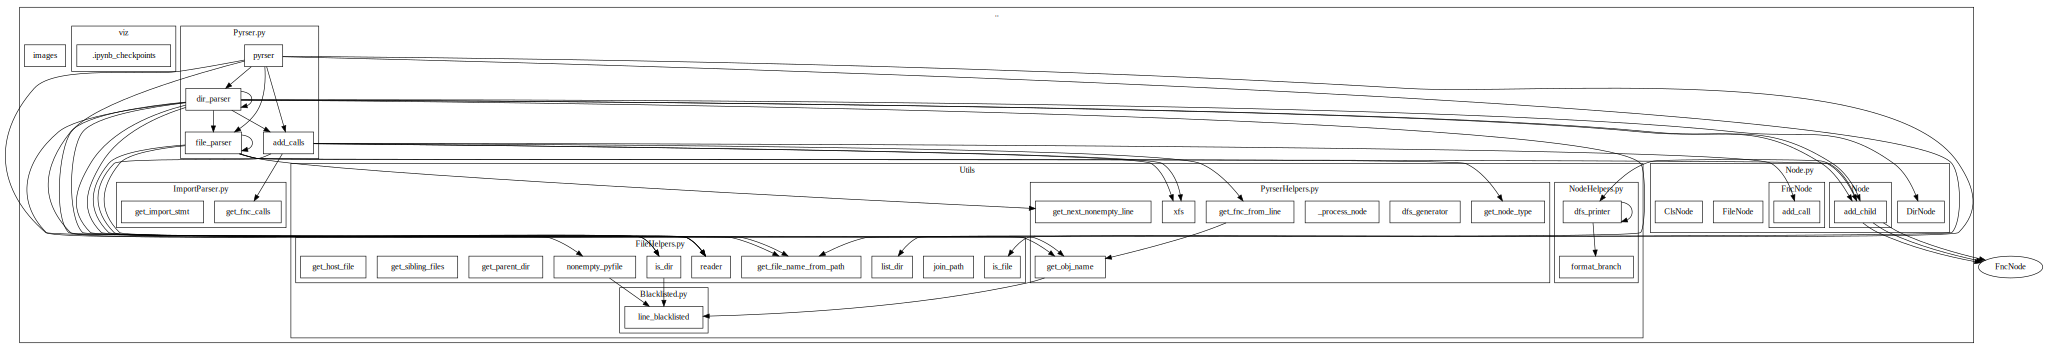

In [18]:
test